In [22]:
### SPUSTIT TOHLE NA PC PŘED PRACÍ !!

import os
import sys
import pydicom # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from glob import glob
from codes.custom_library import Graf_1_2, zaokrouhleni

# Set the working directory to the project directory
device = input("Zadej prosím, na jakém zařízení děláš (mac/doma/prace): ")
if device == "doma":
    project_dir = r"C:/Users/danie/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
elif device == "mac":
    project_dir = r"/Users/danielptacek/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
else:
    project_dir = r"U:/Dokumenty/mrtva_doba_VU"
    os.chdir(project_dir)


# Verify the change
print("Current working directory:", os.getcwd()) 

# Ensure the project directory is in sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

aktivity = {
    "20240708" : 700.589,
    "20240709" : 640.979,
    "20240710" : 586.294,
    "20240711" : 537.692,
    "20240712" : 495.958,
    "20240714" : 404.370,
    "20240715" : 379.365,
    "20240717" : 324.319,
    "20240719" : 266.596,
    "20240721" : 226.576,
    "20240723" : 190.942,
    "20240725" : 158.536,
    "20240726" : 152.496,
    "20240729" : 115.038,
    "20240731" : 93.633,
    "20240805" : 62.613,
    "20240808" : 49.233,
    "20240812" : 34.167,
    "20240815" : 26.602,
    "20240819" : 18.401,
    "20240822" : 14.270,
    "20240826" : 10.122,
    "20240903" : 5.069,
    "20240912" : 2.363
}

Current working directory: /Users/danielptacek/Desktop/mrtva_doba_VU


In [23]:
#### planarni kalibrace Discovery


from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
from codes.custom_library import region_growing
from geom_prumer import geom_prumer
import numpy as np
from glob import glob

kalibrace_folder = "KALIBRACE_20240815/Kalibrace_plan_20240815_Discovery"
kalibrace_mds = sorted(glob(os.path.join(kalibrace_folder, 'Kalibrace*')))

prah = 0.1

####
#### NA ZÁKLADĚ ODHADU REL. NEJISTOTY ČETNOSTI Z POČTU MĚŘENÍ
####
hlava_1_kal_faktory = []
hlava_1_tew_kal_faktory = []
hlava_2_kal_faktory = []
hlava_2_tew_kal_faktory = []
hlavy_gm = []
hlavy_gm_tew = []

hlava_1_kal_cetnosti = []
hlava_1_tew_kal_cetnosti = []
hlava_2_kal_cetnosti = []
hlava_2_tew_kal_cetnosti = []
hlavy_gm_kal_cetnosti = []
hlavy_gm_tew_kal_cetnosti = []

for md in kalibrace_mds:
    image = separate_dicom_file(md)

    acq_time = image["Acq_time"]
    acq_date = image["Acq_date"]

    hlava_1 = image["Head1_EM"]
    hlava_1_tew = tew_correction(image["Head1_EM"], image["Head1_SC1"], image["Head1_SC2"])
    hlava_2 = image["Head2_EM"]
    hlava_2_tew = tew_correction(image["Head2_EM"], image["Head2_SC1"], image["Head2_SC2"])

    maska_1 = region_growing(hlava_1, prah*np.max(hlava_1))
    maska_1_tew = region_growing(hlava_1_tew, prah*np.max(hlava_1_tew))
    maska_2 = region_growing(hlava_2, prah*np.max(hlava_2))
    maska_2_tew = region_growing(hlava_2_tew, prah*np.max(hlava_2_tew))


    kal_cetnost_1 = (np.sum(hlava_1*maska_1) / acq_time) 
    kal_cetnost_1_tew = (np.sum(hlava_1_tew*maska_1_tew) / acq_time) 
    kal_cetnost_2 = (np.sum(hlava_2*maska_2) / acq_time) 
    kal_cetnost_2_tew = (np.sum(hlava_2_tew*maska_2_tew) / acq_time) 
    print(np.sum(hlava_2_tew*maska_2_tew))
    kal_cetnost_gm = (geom_prumer(np.sum(hlava_1*maska_1), np.sum(hlava_2*maska_2)) / acq_time) 
    kal_cetnost_gm_tew = (geom_prumer(np.sum(hlava_1_tew*maska_1_tew), np.sum(hlava_2_tew*maska_2_tew)) / acq_time)

    hlava_1_kal_cetnosti.append(kal_cetnost_1)
    hlava_1_tew_kal_cetnosti.append(kal_cetnost_1_tew)
    hlava_2_kal_cetnosti.append(kal_cetnost_2)
    hlava_2_tew_kal_cetnosti.append(kal_cetnost_2_tew)
    hlavy_gm_kal_cetnosti.append(kal_cetnost_gm)
    hlavy_gm_tew_kal_cetnosti.append(kal_cetnost_gm_tew)

### výpočet relativního odhadu počtu impulsů zakreslením ROI 
rel_odhad_impulsu_hlava_1 = np.std(hlava_1_kal_cetnosti, ddof=1)/np.mean(hlava_1_kal_cetnosti)
rel_odhad_impulsu_hlava_1_tew = np.std(hlava_1_tew_kal_cetnosti, ddof=1)/np.mean(hlava_1_tew_kal_cetnosti)
rel_odhad_impulsu_hlava_2 = np.std(hlava_2_kal_cetnosti, ddof=1)/np.mean(hlava_2_kal_cetnosti)
rel_odhad_impulsu_hlava_2_tew = np.std(hlava_2_tew_kal_cetnosti, ddof=1)/np.mean(hlava_2_tew_kal_cetnosti)
rel_odhad_impulsu_hlavy_gm = np.std(hlavy_gm_kal_cetnosti, ddof=1)/np.mean(hlavy_gm_kal_cetnosti)
rel_odhad_impulsu_hlavy_gm_tew = np.std(hlavy_gm_tew_kal_cetnosti, ddof=1)/np.mean(hlavy_gm_tew_kal_cetnosti)
print(rel_odhad_impulsu_hlava_2_tew)

### výpočet jednotlivých kalibračních koeficientů se svými nejistotami
hlava_1_kal_faktory = np.array(hlava_1_kal_cetnosti)/aktivity[acq_date]
hlava_1_kal_faktory_err = hlava_1_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_1**2 + 0.042**2)

hlava_1_tew_kal_faktory = np.array(hlava_1_tew_kal_cetnosti)/aktivity[acq_date]
hlava_1_tew_kal_faktory_err = hlava_1_tew_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_1_tew**2 + 0.042**2)

hlava_2_kal_faktory = np.array(hlava_2_kal_cetnosti)/aktivity[acq_date]
hlava_2_kal_faktory_err = hlava_2_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_2**2 + 0.042**2)

hlava_2_tew_kal_faktory = np.array(hlava_2_tew_kal_cetnosti)/aktivity[acq_date]
hlava_2_tew_kal_faktory_err = hlava_2_tew_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_2_tew**2 + 0.042**2)

hlavy_gm = np.array(hlavy_gm_kal_cetnosti)/aktivity[acq_date]
hlavy_gm_err = hlavy_gm * np.sqrt(rel_odhad_impulsu_hlavy_gm**2 + 0.042**2)

hlavy_gm_tew = np.array(hlavy_gm_tew_kal_cetnosti)/aktivity[acq_date]
hlavy_gm_tew_err = hlavy_gm_tew * np.sqrt(rel_odhad_impulsu_hlavy_gm_tew**2 + 0.042**2)


### vyprintění jednotlivých průměrných kalibračních koeficientů se svými nejistotami
print("Na základě odhadu rel. nejistoty četnosti impulsů a za pomoci nejistoty aktivity")
print(f"Anterior: {np.mean(hlava_1_kal_faktory)} +- {np.sum(hlava_1_kal_faktory_err**2)/len(hlava_1_kal_faktory_err)}")
print(f"Anterior TEW: {np.mean(hlava_1_tew_kal_faktory)} +- {np.sum(hlava_1_tew_kal_faktory_err**2)/len(hlava_1_tew_kal_faktory_err)}")
print(f"Posterior: {np.mean(hlava_2_kal_faktory)} +- {np.sum(hlava_2_kal_faktory_err**2)/len(hlava_2_kal_faktory_err)}")
print(f"Posterior TEW: {np.mean(hlava_2_tew_kal_faktory)} +- {np.sum(hlava_2_tew_kal_faktory_err**2)/len(hlava_2_tew_kal_faktory_err)}")
print(f"Geom. Mean: {np.mean(hlavy_gm)} +- {np.sum(hlavy_gm_err**2)/len(hlavy_gm_err)}")
print(f"Geom. Mean TEW: {np.mean(hlavy_gm_tew)} +- {np.sum(hlavy_gm_tew_err**2)/len(hlavy_gm_tew_err)}")
print("------")







####
#### NA ZÁKLADĚ VÝBĚROVÉ SMĚRODATNÉ ODCHYLKY PRŮMĚRU
####
hlava_1_kal_faktory = []
hlava_1_tew_kal_faktory = []
hlava_2_kal_faktory = []
hlava_2_tew_kal_faktory = []
hlavy_gm = []
hlavy_gm_tew = []

for md in kalibrace_mds:
    image = separate_dicom_file(md)

    acq_time = image["Acq_time"]
    acq_date = image["Acq_date"]

    hlava_1 = image["Head1_EM"]
    hlava_1_tew = tew_correction(image["Head1_EM"], image["Head1_SC1"], image["Head1_SC2"])
    hlava_2 = image["Head2_EM"]
    hlava_2_tew = tew_correction(image["Head2_EM"], image["Head2_SC1"], image["Head2_SC2"])

    maska_1 = region_growing(hlava_1, prah*np.max(hlava_1))
    maska_1_tew = region_growing(hlava_1_tew, prah*np.max(hlava_1_tew))
    maska_2 = region_growing(hlava_2, prah*np.max(hlava_2))
    maska_2_tew = region_growing(hlava_2_tew, prah*np.max(hlava_2_tew))


    kal_faktor_1 = (np.sum(hlava_1*maska_1) / acq_time) / aktivity[acq_date]
    kal_faktor_1_tew = (np.sum(hlava_1_tew*maska_1_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_2 = (np.sum(hlava_2*maska_2) / acq_time) / aktivity[acq_date]
    kal_faktor_2_tew = (np.sum(hlava_2_tew*maska_2_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_gm = (geom_prumer(np.sum(hlava_1*maska_1), np.sum(hlava_2*maska_2)) / acq_time) / aktivity[acq_date]
    kal_faktor_gm_tew = (geom_prumer(np.sum(hlava_1_tew*maska_1_tew), np.sum(hlava_2_tew*maska_2_tew)) / acq_time) / aktivity[acq_date]


    hlava_1_kal_faktory.append(kal_faktor_1)
    hlava_1_tew_kal_faktory.append(kal_faktor_1_tew)
    hlava_2_kal_faktory.append(kal_faktor_2)
    hlava_2_tew_kal_faktory.append(kal_faktor_2_tew)
    hlavy_gm.append(kal_faktor_gm)
    hlavy_gm_tew.append(kal_faktor_gm_tew)


print("Na základě odhadu pomocí výběrové směrodatné odchylky průměru")
print(f"Anterior: {np.mean(hlava_1_kal_faktory)} +- {np.std(hlava_1_kal_faktory, ddof=1)/np.sqrt(len(hlava_1_kal_faktory))}")
print(f"Anterior TEW: {np.mean(hlava_1_tew_kal_faktory)} +- {np.std(hlava_1_tew_kal_faktory, ddof=1)/np.sqrt(len(hlava_1_tew_kal_faktory))}")
print(f"Posterior: {np.mean(hlava_2_kal_faktory)} +- {np.std(hlava_2_kal_faktory, ddof=1)/np.sqrt(len(hlava_2_kal_faktory))}")
print(f"Posterior TEW: {np.mean(hlava_2_tew_kal_faktory)} +- {np.std(hlava_2_tew_kal_faktory, ddof=1)/np.sqrt(len(hlava_2_tew_kal_faktory))}")
print(f"Geom. Mean: {np.mean(hlavy_gm)} +- {np.std(hlavy_gm, ddof=1)/np.sqrt(len(hlavy_gm))}")
print(f"Geom. Mean TEW: {np.mean(hlavy_gm_tew)} +- {np.std(hlavy_gm_tew, ddof=1)/np.sqrt(len(hlavy_gm_tew))}")

91725.07753260135
91658.48459652488
92071.24745052055
91566.22680595529
91972.89205130938
0.003811537359915244
Na základě odhadu rel. nejistoty četnosti impulsů a za pomoci nejistoty aktivity
Anterior: 24.45827939530902 +- 1.069548819036345
Anterior TEW: 18.875387017177665 +- 0.6297316029289487
Posterior: 8.589710806397132 +- 0.15297984176942692
Posterior TEW: 6.039889669721122 +- 0.06488192409373218
Geom. Mean: 14.494066117422 +- 0.39100259904521184
Geom. Mean TEW: 10.67729931174871 +- 0.2014646236855145
------
Na základě odhadu pomocí výběrové směrodatné odchylky průměru
Anterior: 24.45827939530902 +- 0.05346114658467882
Anterior TEW: 18.875387017177665 +- 0.015820863895733565
Posterior: 8.589710806397132 +- 0.06751089885772864
Posterior TEW: 6.039889669721122 +- 0.010295422749915255
Geom. Mean: 14.494066117422 +- 0.06386661980980506
Geom. Mean TEW: 10.67729931174871 +- 0.008482781607107135


Na základě odhadu rel. nejistoty četnosti impulsů a za pomoci nejistoty aktivity
Anterior: 20.882145297679973 +- 0.772067948428341
Anterior TEW: 17.069682253805375 +- 0.5219206349899146
Posterior: 6.882601433877871 +- 0.08540076279266369
Posterior TEW: 5.137849191114297 +- 0.04726437338161374
Geom. Mean: 11.988389324342121 +- 0.2542821213352683
Geom. Mean TEW: 9.364841296961004 +- 0.1555552195545837
------
Na základě odhadu pomocí výběrové směrodatné odchylky průměru
Anterior: 20.712146394230594 +- 0.03133781063280813
Anterior TEW: 16.998111356531943 +- 0.03572394841209739
Posterior: 6.752001277731715 +- 0.016327868194295707
Posterior TEW: 5.118460486933801 +- 0.012869616951069304
Geom. Mean: 11.825676924951127 +- 0.0108703919009089
Geom. Mean TEW: 9.327537868572401 +- 0.012932172246528248


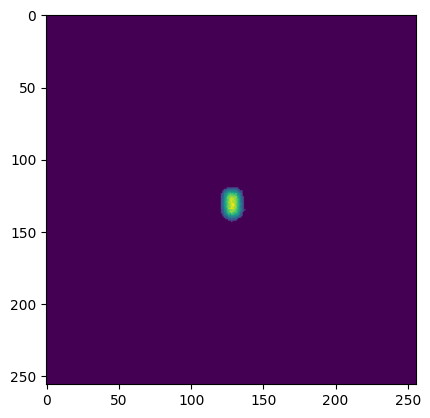

In [31]:
#### planarni kalibrace Optima


from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
from codes.custom_library import region_growing
from geom_prumer import geom_prumer
import numpy as np
from glob import glob

kalibrace_folder = "KALIBRACE_20240815/Kalibrace_plan_20240815_Optima"
kalibrace_mds = sorted(glob(os.path.join(kalibrace_folder, 'Kalibrace*')))

prah = 0.2

####
#### NA ZÁKLADĚ ODHADU REL. NEJISTOTY ČETNOSTI Z POČTU MĚŘENÍ
####
hlava_1_kal_faktory = []
hlava_1_tew_kal_faktory = []
hlava_2_kal_faktory = []
hlava_2_tew_kal_faktory = []
hlavy_gm = []
hlavy_gm_tew = []

hlava_1_kal_cetnosti = []
hlava_1_tew_kal_cetnosti = []
hlava_2_kal_cetnosti = []
hlava_2_tew_kal_cetnosti = []
hlavy_gm_kal_cetnosti = []
hlavy_gm_tew_kal_cetnosti = []

for md in kalibrace_mds:
    image = separate_dicom_file(md)

    acq_time = image["Acq_time"]
    acq_date = image["Acq_date"]

    hlava_1 = image["Head1_EM"]
    hlava_1_tew = tew_correction(image["Head1_EM"], image["Head1_SC1"], image["Head1_SC2"])
    hlava_2 = image["Head2_EM"]
    hlava_2_tew = tew_correction(image["Head2_EM"], image["Head2_SC1"], image["Head2_SC2"])

    maska_1 = region_growing(hlava_1, prah*(np.max(hlava_1) - np.mean(hlava_1[148:163, 105:155])))
    maska_1_tew = region_growing(hlava_1_tew, prah*(np.max(hlava_1_tew) - np.mean(hlava_1_tew[148:163, 105:155])))
    maska_2 = region_growing(hlava_2, prah*(np.max(hlava_2) - np.mean(hlava_2[148:163, 105:155])))
    maska_2_tew = region_growing(hlava_2_tew, prah*(np.max(hlava_2_tew) - np.mean(hlava_2_tew[148:163, 105:155])))


    kal_cetnost_1 = (np.sum(hlava_1*maska_1) / acq_time) 
    kal_cetnost_1_tew = (np.sum(hlava_1_tew*maska_1_tew) / acq_time) 
    kal_cetnost_2 = (np.sum(hlava_2*maska_2) / acq_time) 
    kal_cetnost_2_tew = (np.sum(hlava_2_tew*maska_2_tew) / acq_time) 
    kal_cetnost_gm = (geom_prumer(np.sum(hlava_1*maska_1), np.sum(hlava_2*maska_2)) / acq_time) 
    kal_cetnost_gm_tew = (geom_prumer(np.sum(hlava_1_tew*maska_1_tew), np.sum(hlava_2_tew*maska_2_tew)) / acq_time)

    hlava_1_kal_cetnosti.append(kal_cetnost_1)
    hlava_1_tew_kal_cetnosti.append(kal_cetnost_1_tew)
    hlava_2_kal_cetnosti.append(kal_cetnost_2)
    hlava_2_tew_kal_cetnosti.append(kal_cetnost_2_tew)
    hlavy_gm_kal_cetnosti.append(kal_cetnost_gm)
    hlavy_gm_tew_kal_cetnosti.append(kal_cetnost_gm_tew)

### výpočet relativního odhadu počtu impulsů zakreslením ROI 
rel_odhad_impulsu_hlava_1 = np.std(hlava_1_kal_cetnosti, ddof=1)/np.mean(hlava_1_kal_cetnosti)
rel_odhad_impulsu_hlava_1_tew = np.std(hlava_1_tew_kal_cetnosti, ddof=1)/np.mean(hlava_1_tew_kal_cetnosti)
rel_odhad_impulsu_hlava_2 = np.std(hlava_2_kal_cetnosti, ddof=1)/np.mean(hlava_2_kal_cetnosti)
rel_odhad_impulsu_hlava_2_tew = np.std(hlava_2_tew_kal_cetnosti, ddof=1)/np.mean(hlava_2_tew_kal_cetnosti)
rel_odhad_impulsu_hlavy_gm = np.std(hlavy_gm_kal_cetnosti, ddof=1)/np.mean(hlavy_gm_kal_cetnosti)
rel_odhad_impulsu_hlavy_gm_tew = np.std(hlavy_gm_tew_kal_cetnosti, ddof=1)/np.mean(hlavy_gm_tew_kal_cetnosti)


### výpočet jednotlivých kalibračních koeficientů se svými nejistotami
hlava_1_kal_faktory = np.array(hlava_1_kal_cetnosti)/aktivity[acq_date]
hlava_1_kal_faktory_err = hlava_1_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_1**2 + 0.042**2)

hlava_1_tew_kal_faktory = np.array(hlava_1_tew_kal_cetnosti)/aktivity[acq_date]
hlava_1_tew_kal_faktory_err = hlava_1_tew_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_1_tew**2 + 0.042**2)

hlava_2_kal_faktory = np.array(hlava_2_kal_cetnosti)/aktivity[acq_date]
hlava_2_kal_faktory_err = hlava_2_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_2**2 + 0.042**2)

hlava_2_tew_kal_faktory = np.array(hlava_2_tew_kal_cetnosti)/aktivity[acq_date]
hlava_2_tew_kal_faktory_err = hlava_2_tew_kal_faktory * np.sqrt(rel_odhad_impulsu_hlava_2_tew**2 + 0.042**2)

hlavy_gm = np.array(hlavy_gm_kal_cetnosti)/aktivity[acq_date]
hlavy_gm_err = hlavy_gm * np.sqrt(rel_odhad_impulsu_hlavy_gm**2 + 0.042**2)

hlavy_gm_tew = np.array(hlavy_gm_tew_kal_cetnosti)/aktivity[acq_date]
hlavy_gm_tew_err = hlavy_gm_tew * np.sqrt(rel_odhad_impulsu_hlavy_gm_tew**2 + 0.042**2)


### vyprintění jednotlivých průměrných kalibračních koeficientů se svými nejistotami
print("Na základě odhadu rel. nejistoty četnosti impulsů a za pomoci nejistoty aktivity")
print(f"Anterior: {np.mean(hlava_1_kal_faktory)} +- {np.sum(hlava_1_kal_faktory_err**2)/len(hlava_1_kal_faktory_err)}")
print(f"Anterior TEW: {np.mean(hlava_1_tew_kal_faktory)} +- {np.sum(hlava_1_tew_kal_faktory_err**2)/len(hlava_1_tew_kal_faktory_err)}")
print(f"Posterior: {np.mean(hlava_2_kal_faktory)} +- {np.sum(hlava_2_kal_faktory_err**2)/len(hlava_2_kal_faktory_err)}")
print(f"Posterior TEW: {np.mean(hlava_2_tew_kal_faktory)} +- {np.sum(hlava_2_tew_kal_faktory_err**2)/len(hlava_2_tew_kal_faktory_err)}")
print(f"Geom. Mean: {np.mean(hlavy_gm)} +- {np.sum(hlavy_gm_err**2)/len(hlavy_gm_err)}")
print(f"Geom. Mean TEW: {np.mean(hlavy_gm_tew)} +- {np.sum(hlavy_gm_tew_err**2)/len(hlavy_gm_tew_err)}")
print("------")







####
#### NA ZÁKLADĚ VÝBĚROVÉ SMĚRODATNÉ ODCHYLKY PRŮMĚRU
####
hlava_1_kal_faktory = []
hlava_1_tew_kal_faktory = []
hlava_2_kal_faktory = []
hlava_2_tew_kal_faktory = []
hlavy_gm = []
hlavy_gm_tew = []

for md in kalibrace_mds:
    image = separate_dicom_file(md)

    acq_time = image["Acq_time"]
    acq_date = image["Acq_date"]

    hlava_1 = image["Head1_EM"]
    hlava_1_tew = tew_correction(image["Head1_EM"], image["Head1_SC1"], image["Head1_SC2"])
    hlava_2 = image["Head2_EM"]
    hlava_2_tew = tew_correction(image["Head2_EM"], image["Head2_SC1"], image["Head2_SC2"])

    maska_1 = region_growing(hlava_1, prah*np.max(hlava_1))
    plt.imshow(maska_1*hlava_1)
    maska_1_tew = region_growing(hlava_1_tew, prah*np.max(hlava_1_tew))
    maska_2 = region_growing(hlava_2, prah*np.max(hlava_2))
    maska_2_tew = region_growing(hlava_2_tew, prah*np.max(hlava_2_tew))


    kal_faktor_1 = (np.sum(hlava_1*maska_1) / acq_time) / aktivity[acq_date]
    kal_faktor_1_tew = (np.sum(hlava_1_tew*maska_1_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_2 = (np.sum(hlava_2*maska_2) / acq_time) / aktivity[acq_date]
    kal_faktor_2_tew = (np.sum(hlava_2_tew*maska_2_tew) / acq_time) / aktivity[acq_date]
    kal_faktor_gm = (geom_prumer(np.sum(hlava_1*maska_1), np.sum(hlava_2*maska_2)) / acq_time) / aktivity[acq_date]
    kal_faktor_gm_tew = (geom_prumer(np.sum(hlava_1_tew*maska_1_tew), np.sum(hlava_2_tew*maska_2_tew)) / acq_time) / aktivity[acq_date]


    hlava_1_kal_faktory.append(kal_faktor_1)
    hlava_1_tew_kal_faktory.append(kal_faktor_1_tew)
    hlava_2_kal_faktory.append(kal_faktor_2)
    hlava_2_tew_kal_faktory.append(kal_faktor_2_tew)
    hlavy_gm.append(kal_faktor_gm)
    hlavy_gm_tew.append(kal_faktor_gm_tew)


print("Na základě odhadu pomocí výběrové směrodatné odchylky průměru")
print(f"Anterior: {np.mean(hlava_1_kal_faktory)} +- {np.std(hlava_1_kal_faktory, ddof=1)/np.sqrt(len(hlava_1_kal_faktory))}")
print(f"Anterior TEW: {np.mean(hlava_1_tew_kal_faktory)} +- {np.std(hlava_1_tew_kal_faktory, ddof=1)/np.sqrt(len(hlava_1_tew_kal_faktory))}")
print(f"Posterior: {np.mean(hlava_2_kal_faktory)} +- {np.std(hlava_2_kal_faktory, ddof=1)/np.sqrt(len(hlava_2_kal_faktory))}")
print(f"Posterior TEW: {np.mean(hlava_2_tew_kal_faktory)} +- {np.std(hlava_2_tew_kal_faktory, ddof=1)/np.sqrt(len(hlava_2_tew_kal_faktory))}")
print(f"Geom. Mean: {np.mean(hlavy_gm)} +- {np.std(hlavy_gm, ddof=1)/np.sqrt(len(hlavy_gm))}")
print(f"Geom. Mean TEW: {np.mean(hlavy_gm_tew)} +- {np.std(hlavy_gm_tew, ddof=1)/np.sqrt(len(hlavy_gm_tew))}")